## Importing the necesssary Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import psycopg2 as pg2
import datetime as dt
# package used for converting the data into datetime format
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

## Execution time counter
#%load_ext autotime

## Establish connection to the PostgreSQL database

In [2]:
conn= pg2.connect('dbname = Amazon user= postgres password =data host= 127.0.0.1')
cur=conn.cursor()
df_raw = pd.read_sql_query('select * from public.keepa', conn)

In [3]:
#Check the dimension of the raw data to see if its properly imported
print('Starting size of our Dataset ')
df_raw.shape

Starting size of our Dataset 


(100192, 79)

In [4]:
# Print out count of each datatype in the dataframe
df_raw.dtypes.value_counts()

object    77
int64      2
dtype: int64

### Price Aggregator

Amazon's listing price for books is stored in one of three columns in keepa's Amazon Price Tracker data dump we obtained for this capstone project. If Amazon is fullfilling the sale, the price comes from amazon_price column. But if the book is sold by a third party seller,  the listing price would be marketplace_new_price for new books and for used ones the listing price will be marketplace_used_price.  

We  are  combing the three columns in to one called 'price' and assign its value based on the the given price assignment information.

The aggregator function adds the new column to the dataset and assigns the value that appers first from the following list and finally drops the three columns from the dataset.      
         * amazon_Price        
         * marketplace_new        
         * marketplace_used_price

In [5]:

def PriceAggregator(original_df):
    
    df=original_df
    # create a copy of the three columns to choose amazon price from
    df_copy=df[['amazon_price','marketplace_new_price','marketplace_used_price']]
    
    # Replace missing price denoted by -1 to Null in all three price columns   
    for item in df_copy:
        df_copy[item].replace('-1',np.nan, inplace=True)
        
    # Add a new column to store the aggregated price with default value of 'amazon_price'         
    df.insert(79,'price',df_copy['amazon_price'].astype('float'))
    
    
    #Loop throgh all three columns to assign non-null value to the newly created price column. 
    #Keep amazon_price as is if not null, otherwise assign marketplace_new_price as the new price. 
    #Where both 'amazon_price' and 'marketplace_new_price' are null, price will be set to 
    #'marketplace_used_price' regardless of its value.
    
    for i in range(df['price'].size):
        if pd.isnull(df['price'][i]):
            if pd.isnull(df_copy['marketplace_new_price'][i]):
                if pd.isnull(df_copy['marketplace_used_price'][i]):
                    pass
                else:
                    df['price'][i]=df_copy['marketplace_used_price'][i]
            else:
                df['price'][i]=df_copy['marketplace_new_price'][i]
        else:
            pass
    
    # Delete records where price value is missing since that is what we are trying to predict 
    df.dropna(subset=['price'], axis=0, inplace=True)
    
    #Reset index after dropping rows with missing price
    df.reset_index(drop= True, inplace=True)
    
    #Delete old price columns after assigning aggregated price to a brand new column    
    df.drop(['amazon_price','marketplace_new_price','marketplace_used_price'], axis=1 , inplace=True)
    
    #Return the a dataframe with a new price column added to the original dataframe
    return df   
    
    

In [6]:
df=PriceAggregator(df_raw)

In [7]:
df.shape

(99658, 77)

## Delete duplicate records, if there are any.

In [8]:
# data size before deleting duplicates
df.shape

(99658, 77)

In [9]:
df.drop_duplicates(inplace = True)

In [10]:
# data size after deleting duplicates
df.shape

(99600, 77)

We can see from .shape() function that there are 99600 unique records with 77 features in the dataset.

## Understanding the Data

In [11]:
# Highlight of the dataframe
df.head(3)

,productType,asin,author,availabilityAmazon,binding,brand,buyBoxSellerIdHistory,categoryTree_0,categoryTree_1,categoryTree_2,...,studio,title,trackingSince,type,upc,upcList,variationCSV,variations,sales_rank,price
0,1,B017WJ5PR4,J.K. Rowling,0,Audible Audiobook,,,Books,Subjects,Teen & Young Adult,...,Pottermore Publishing,"Harry Potter and the Deathly Hallows, Book 7",3796800,DOWNLOADABLE_AUDIO,0,,,,41,4499.0
1,1,B07H4WPSS2,Adam Grant,0,Audible Audiobook,,,Books,Subjects,Biographies & Memoirs,...,Audible Studios,Power Moves: Lessons from Davos,4060296,DOWNLOADABLE_AUDIO,0,,,,43,696.0
2,0,038538369X,Naomi Kleinberg,0,Board book,Random House Books for Young Readers,,Books,Subjects,Children's Books,...,Random House Books for Young Readers,P is for Potty! (Sesame Street) (Lift-the-Flap),1708140,ABIS_BOOK,0,,,,30,599.0


Descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution,

In [12]:
df.describe(include= 'all' )

,productType,asin,author,availabilityAmazon,binding,brand,buyBoxSellerIdHistory,categoryTree_0,categoryTree_1,categoryTree_2,...,studio,title,trackingSince,type,upc,upcList,variationCSV,variations,sales_rank,price
count,99600.000000,99600,99600,99600,99600,99600,99600,99594,99594,96636,...,99600,99600,99600,99600,99600,92565,99600,99600,99600,99600.000000
unique,NaN,99467,37563,4,73,7403,1,12,16,46,...,10107,89646,52318,45,7018,1,33,1,60449,NaN
top,NaN,1930238371,,0,Audible Audiobook,,,Books,Subjects,Literature & Fiction,...,Audible Studios,Think and Grow Rich,119040,ABIS_BOOK,0,,,,258,NaN
freq,NaN,2,2060,95037,44619,67295,99600,99576,99576,17441,...,4267,15,4510,54138,92565,92565,99541,99600,11,NaN
mean,0.451878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1981.619367
std,0.508459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3067.885740
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1045.000000
50%,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1524.000000
75%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2195.000000


The data was stored in the PostgreSQL database as text(string) type and running discriptive statistics with .describe() on the dataframe doesnt tell us much until we do the proper type conversion.

 # Data Wrangling 
 
Data wrangling is the process of converting data from the initial format to a format that may be better for analysis. As part of the wrangling process we are applying different techniques to comeup with a cleaner and complete dataset to apply machine learning. Here are some of he steps we are following;
    - Identify Missing Values
    - Replace or Delete Missing Values
    - Correct Data format
    - Aggregate highly related categorical values where necessary

### Replace missing values with Null Values.

We will replace every missing values with Numpy Null inorder to keep uniformity and computational speed.  

In [13]:
df.fillna(np.NaN)
df.replace('', np.NaN, inplace=True)

In [14]:
## count and sort null values in every coulumn in descending order
df.isna().sum().sort_values(ascending=False).to_frame(name='Count of Null Values')

,Count of Null Values
coupon,99600
offers,99600
liveOffersOrder,99600
promotions,99600
buyBoxSellerIdHistory,99600
features,99600
upcList,99600
variations,99600
hazardousMaterialType,99599
genre,99565


Null or missing value implies that we dont have information about that feature for an entry in the dataset. We can delete those features that contain Null values for the majority of the recordset because keeping them will not contribute enough signal to the data.

In [15]:
## create a list of features that contain null value for more than 50% of the records based on the the above observation
Null_features=['coupon','offers','liveOffersOrder','promotions','buyBoxSellerIdHistory','features','upcList','variations',
               'hazardousMaterialType','genre','platform','variationCSV','parentAsin','department','size','model','color'
               ,'partNumber','mpn','brand','edition','format']

In [16]:
# Column names with Number of Null values contained in them
df[Null_features].isna().sum()

coupon                   99600
offers                   99600
liveOffersOrder          99600
promotions               99600
buyBoxSellerIdHistory    99600
features                 99600
upcList                  99600
variations               99600
hazardousMaterialType    99599
genre                    99565
platform                 99551
variationCSV             99541
parentAsin               99404
department               99087
size                     98585
model                    96864
color                    96533
partNumber               68582
mpn                      68560
brand                    67295
edition                  65652
format                   52034
dtype: int64

   
We can delete these features without losing any useful information from our data since more than 50% of the records in the above list contain null values. 
   

In [17]:
## delete columns that contain very high count null values 
df.drop(Null_features, axis=1, inplace=True)

In [18]:
# check the shape of the dataset to confirm the features are dropped
df.shape

(99600, 55)

For the remaining Null values in our data where the total count is relatively small, we will replace them by  a statistically representative values like mean or mode.

  * Mode for categorical values where there is a clear majority or will be replaced 'Unknown'
  * Mean value is used for numerical columns

In [19]:
#Assigns column names that contain null values to a list
with_Nulls=df.loc[:, df.isna().sum()!=0].columns.tolist()

In [20]:
#Lists down the number of null values in every column in descending order
df[with_Nulls].isna().sum().sort_values(ascending=False)

categoryTree_4    34740
categoryTree_3     7172
categoryTree_2     2964
author             2060
languages_0         493
studio              106
publisher           106
manufacturer        106
label               106
binding             102
imagesCSV            60
categoryTree_1        6
categoryTree_0        6
dtype: int64

In [21]:
# let's see what kind of information is in each column
df[with_Nulls].head(5)

,author,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,imagesCSV,label,languages_0,manufacturer,publisher,studio
0,J.K. Rowling,Audible Audiobook,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,917XxoD2LaL.jpg,Pottermore Publishing,"English,Published",Pottermore Publishing,Pottermore Publishing,Pottermore Publishing
1,Adam Grant,Audible Audiobook,Books,Subjects,Biographies & Memoirs,Memoirs,None,81Gwx%2BmKSEL.jpg,Audible Studios,"English,Published",Audible Studios,Audible Studios,Audible Studios
2,Naomi Kleinberg,Board book,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,"91Nr-1lyMJL.jpg,81wHBCfxbYL.jpg,51vaGx5y9iL.jp...",Random House Books for Young Readers,"English,Published",Random House Books for Young Readers,Random House Books for Young Readers,Random House Books for Young Readers
3,Jen Fisch,Paperback,Books,Subjects,"Cookbooks, Food & Wine",Regional & International,Canadian,"81It%2BExKfoL.jpg,71r6m-frl3L.jpg,A1QninHxorL....",Rockridge Press,"English,Published",Rockridge Press,Rockridge Press,Rockridge Press
4,Elizabeth Cunningham,Paperback,Books,Subjects,"Cookbooks, Food & Wine",Baking,Cakes,51mxjPJXEaL.jpg,Independently published,"English,Published",Independently published,Independently published,Independently published


The sample shows that the records are mainly comprised of string or categorival values. Lets further divide the series based on the number of missing (Null) values.

In [22]:

Nulls2Unknown=['categoryTree_4','categoryTree_3','categoryTree_2','author','studio','publisher','manufacturer',
              'label']

In [23]:
#print out the highest frequency value(Mode) in the given list of features, it only shows the count not the value. 
#Based on the count we can tell if there's a statistical representative mode value to replace the nulls.  
for item in with_Nulls:
    print(f'{item}\t\t{df[item].value_counts().max()}')

author		319
binding		44619
categoryTree_0		99576
categoryTree_1		99576
categoryTree_2		17441
categoryTree_3		8216
categoryTree_4		2704
imagesCSV		4
label		4267
languages_0		95316
manufacturer		4267
publisher		4267
studio		4267


Given that our data contains 100,000 records we can clearly see the high mode value for some of the features to replace the nulls.

In [24]:
# The following 3 features have very high Mode value, therefore we'll replace nulls by mode
Nulls2Mode=['languages_0','categoryTree_0','categoryTree_1']

In [25]:
mode = df.filter(['languages_0','categoryTree_0','categoryTree_1']).mode()
df[Nulls2Mode]=df[Nulls2Mode].fillna(df.mode().iloc[0])

       
     
               
  
  
For the following features since there is no one single category with a high frequency(Mode) in the group, we are filling the missing(Null) values with 'Unknown'.
  

In [26]:
 
NullswithNoMode=df.loc[:, df.isna().sum()!=0].columns.tolist()


In [27]:
#Based on the top 3 most frequent records in each column, it shows that there is no dominant value that can be used
#as a mode to replace null values. We are therefore replacing null values with 'Unknown'.
for item in NullswithNoMode:
    print(item)
    print(df[item].value_counts().nlargest(3))
    print('Total Number of null values in %s = %d' % (item,df[item].isna().sum()))
    print('')

author
James Patterson    319
DK                 306
Stephen King       186
Name: author, dtype: int64
Total Number of null values in author = 2060

binding
Audible Audiobook    44619
Paperback            35263
Hardcover            13342
Name: binding, dtype: int64
Total Number of null values in binding = 102

categoryTree_2
Literature & Fiction    17441
Children's Books        12742
Self-Help                9712
Name: categoryTree_2, dtype: int64
Total Number of null values in categoryTree_2 = 2964

categoryTree_3
Genre Fiction       8216
Christian Living    3547
Animals             3516
Name: categoryTree_3, dtype: int64
Total Number of null values in categoryTree_3 = 7172

categoryTree_4
Historical       2704
Family Life      2249
United States    1988
Name: categoryTree_4, dtype: int64
Total Number of null values in categoryTree_4 = 34740

imagesCSV
51sV88-zsdL.jpg    4
41CVkZuDlVL.jpg    3
51lwDPW8IsL.jpg    3
Name: imagesCSV, dtype: int64
Total Number of null values in imagesCSV 

In [28]:
# Replace nulls with 'Unknown' for multimodel features
df[NullswithNoMode]=df[NullswithNoMode].fillna('Unknown')

In [29]:
# Check if there are still missing or null values in the dataset
df[df.loc[:, df.isna().sum()!=0].columns].isna().sum()

Series([], dtype: float64)

We have entirely replaced the null and missing values in the dataset by statistically representative values.

## Data Type Conversion

In [30]:
df.dtypes.value_counts()

object     52
int64       2
float64     1
dtype: int64

The data imported from postgreSQL to pandas dataframe contains columns as type object(string). Most of those features are actually nemerical values, and we will convert the data type in to the proper format. 

Lets group all those features that are in string (object) format and convert them to numeric

In [31]:
df.dtypes.value_counts()

object     52
int64       2
float64     1
dtype: int64

In [32]:
#Convert columns that contain numerical values to numeric data type using pandsas to_numeric
numeric=['availabilityAmazon',
       'ean','hasReviews', 'isEligibleForSuperSaverShipping', 'isEligibleForTradeIn',
       'isRedirectASIN', 'isSNS', 'lastPriceChange','lastRatingUpdate', 'lastUpdate', 'listedSince', 
       'newPriceIsMAP', 'numberOfItems','numberOfPages', 'offersSuccessful', 'packageHeight',
       'packageLength', 'packageQuantity', 'packageWeight', 'packageWidth',
       'publicationDate', 'releaseDate', 'rootCategory','stats_atIntervalStart', 'stats_avg', 'stats_avg30', 'stats_avg90',
       'stats_avg180', 'stats_current', 'stats_outOfStockPercentage30',
       'stats_outOfStockPercentage90', 'stats_outOfStockPercentageInInterval',
       'trackingSince','sales_rank', 'price']
#cols = ['productType','rootCategory','stats_atIntervalStart','availabilityAmazon','hasReviews','isRedirectASIN','isSNS','isEligibleForTradeIn','isEligibleForSuperSaverShipping', 'ean','hasReviews', 'availabilityAmazon','isEligibleForTradeIn','lastPriceChange','lastRatingUpdate','lastUpdate','lastRatingUpdate','lastUpdate','listedSince',"newPriceIsMAP", "numberOfItems", "numberOfPages","packageHeight", "packageLength","packageQuantity", "packageWeight", "packageWidth",'stats_avg', 'stats_avg30', 'stats_avg90', 'stats_avg180', 'stats_current',"stats_outOfStockPercentage30", "stats_outOfStockPercentage90","stats_outOfStockPercentageInInterval","trackingSince",'upc','price','amazon_price', 'marketplace_new_price', 'marketplace_used_price', 'sales_rank']
df[numeric] = df[numeric].apply(pd.to_numeric, errors='coerce', axis=1)

In [33]:
df.dtypes.value_counts()

float64    35
object     18
int64       2
dtype: int64

In [34]:
strings=df.loc[:, df.dtypes == np.object].columns.tolist()
print('\n'+ 'Sample of the dataset with only categorical information'+'\n')
df[strings].head(3)


Sample of the dataset with only categorical information



,asin,author,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,imagesCSV,label,languages_0,manufacturer,productGroup,publisher,studio,title,type,upc
0,B017WJ5PR4,J.K. Rowling,Audible Audiobook,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,917XxoD2LaL.jpg,Pottermore Publishing,"English,Published",Pottermore Publishing,Audible,Pottermore Publishing,Pottermore Publishing,"Harry Potter and the Deathly Hallows, Book 7",DOWNLOADABLE_AUDIO,0
1,B07H4WPSS2,Adam Grant,Audible Audiobook,Books,Subjects,Biographies & Memoirs,Memoirs,Unknown,81Gwx%2BmKSEL.jpg,Audible Studios,"English,Published",Audible Studios,Audible,Audible Studios,Audible Studios,Power Moves: Lessons from Davos,DOWNLOADABLE_AUDIO,0
2,038538369X,Naomi Kleinberg,Board book,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,"91Nr-1lyMJL.jpg,81wHBCfxbYL.jpg,51vaGx5y9iL.jp...",Random House Books for Young Readers,"English,Published",Random House Books for Young Readers,Book,Random House Books for Young Readers,Random House Books for Young Readers,P is for Potty! (Sesame Street) (Lift-the-Flap),ABIS_BOOK,0


We can delete 'asin', 'ean' and 'imageCSV' columns since the information contained in them is not characteristic discription of books.

In [35]:
df.drop(['asin','imagesCSV','ean', 'upc'], axis=1, inplace=True)

In [36]:
df.shape

(99600, 51)

In [37]:
df.dtypes.value_counts()

float64    34
object     15
int64       2
dtype: int64

In [38]:
# Print features that are of object type
df.loc[:, df.dtypes == np.object].columns

Index(['author', 'binding', 'categoryTree_0', 'categoryTree_1',
       'categoryTree_2', 'categoryTree_3', 'categoryTree_4', 'label',
       'languages_0', 'manufacturer', 'productGroup', 'publisher', 'studio',
       'title', 'type'],
      dtype='object')

 

Information regarding what language a book is written in and whether its an original print or translated version is recorded in the 'language_0' column. These two information are separated by comma, this column can be split into two parts and stored separately inorder to reduce categorical data we have to encode later.

    


In [39]:
df['languages_0'].head(5)

0    English,Published
1    English,Published
2    English,Published
3    English,Published
4    English,Published
Name: languages_0, dtype: object

In [40]:
new = df['languages_0'].str.split(",", n = 1, expand = True)

In [41]:
df['language_1']=new[0]
df['language_2']=new[1]

In [42]:
# reduced categories froom 9 to 6 grouping related categories together
#df['language_1'].value_counts().to_frame()

In [43]:
#group English, english and Middle English to one categry
df['language_1'].replace(('English', 'english','Middle English'),'English', inplace = True)

#grouping Spanish,Portuguese and Latin under "Spanish"
df['language_1'].replace(('Spanish', 'Portuguese','Latin'),'Spanish', inplace = True)

#grouping Chinese, mandarin Chinese and simplified chinese to Chinese 
df['language_1'].replace(('Simplified Chinese', 'Mandarin Chinese','Chinese'),'Chinese', inplace = True)

#grouping Arabic,Hebrew and Turkish under Middle Eastern
df['language_1'].replace(('Arabic', 'Hebrew','Turkish'),'Middle Eastern', inplace = True)

# group languages with single entry record in to one group called 'Others'
df['language_1'].replace(('Hindi', 'Scots','Filipino','Malay','Dutch','Greek','Korean','Romanian','Czech'),'Others', inplace = True)


#grouping Danish and Norwegian into one group of 'Scandinavian'  
df['language_1'].replace(('Danish', 'Norwegian'),'Scandinavian', inplace=True)

In [44]:
#replaced ('published','Published,Dolby Digital 1.0','Published,DTS-HD 5.1') by Published
df['language_2'].replace(('published','Published,Dolby Digital 1.0','Published,DTS-HD 5.1'),'Published', inplace=True)

In [45]:
df[['language_1','language_2']].head(5)

,language_1,language_2
0,English,Published
1,English,Published
2,English,Published
3,English,Published
4,English,Published


In [46]:
#Since we have copied the information into new columns we can delete the languages_0 column
df.drop(['languages_0'], axis=1 , inplace=True)

In [47]:
df.columns

Index(['productType', 'author', 'availabilityAmazon', 'binding',
       'categoryTree_0', 'categoryTree_1', 'categoryTree_2', 'categoryTree_3',
       'categoryTree_4', 'domainId', 'hasReviews',
       'isEligibleForSuperSaverShipping', 'isEligibleForTradeIn',
       'isRedirectASIN', 'isSNS', 'label', 'lastPriceChange',
       'lastRatingUpdate', 'lastUpdate', 'listedSince', 'manufacturer',
       'newPriceIsMAP', 'numberOfItems', 'numberOfPages', 'offersSuccessful',
       'packageHeight', 'packageLength', 'packageQuantity', 'packageWeight',
       'packageWidth', 'productGroup', 'publicationDate', 'publisher',
       'releaseDate', 'rootCategory', 'stats_atIntervalStart', 'stats_avg',
       'stats_avg30', 'stats_avg90', 'stats_avg180', 'stats_current',
       'stats_outOfStockPercentage30', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentageInInterval', 'studio', 'title',
       'trackingSince', 'type', 'sales_rank', 'price', 'language_1',
       'language_2'],
     

In [48]:
df.shape

(99600, 52)

In [49]:
#Cleaning binding column
df.binding.value_counts()

Audible Audiobook              44619
Paperback                      35263
Hardcover                      13342
Board book                      1633
Mass Market Paperback           1260
Spiral-bound                     611
Cards                            459
Calendar                         326
Imitation Leather                283
Map                              201
Pamphlet                         187
Perfect Paperback                162
Diary                            132
Audio CD                         116
Unknown                          102
Misc. Supplies                    90
Sheet music                       84
Leather Bound                     79
Flexibound                        76
Hardcover-spiral                  53
Loose Leaf                        52
Game                              47
Plastic Comb                      40
Software Download                 39
Electronics                       30
Bonded Leather                    27
Single Issue Magazine             26
B

The binding column contains 73 differnt categories that are mostly related and some of them contain very small elements, we will aggregate closely related categories to reduce the dimension of our variables to avoid curse of dimensionality 


In [50]:
df.binding.nunique()

73

In [51]:
# create a dictionary of identiacal items to create a group an aggregate category 
dict={'Unknown':['Printed Access Code', 'Unknown','Health and Beauty', 'Lawn & Patio', 'Workbook', 'Kitchen', 'Automotive', 'Jewelry'],
     'spiral':[ 'Spiral-bound', 'Staple Bound', 'Ring-bound', 'Plastic Comb', 'Loose Leaf', 'Thread Bound'],
     'magazines':[ 'Journal', 'Single Issue Magazine', 'Print Magazine'],
     'audios':[ 'Audible Audiobook', 'Audio CD', 'DVD', 'Album', 'MP3 CD', 'Audio CD Library Binding'],
     'digital_prints':[ 'CD-ROM', 'Blu-ray', 'DVD-ROM', 'Kindle Edition', 'Video Game', 'Sheet music', 'Software Download',
 'Personal Computers', 'Electronics', 'Game', 'Wireless Phone Accessory'],
     'hardcovers':['Hardcover', 'Hardcover-spiral', 'Turtleback', 'Roughcut'],
     'others':[ 'Cards', 'Pamphlet', 'Calendar', 'Map', 'Stationery', 'Accessory', 'Misc. Supplies', 'Office Product', 'Poster',
 'Wall Chart', 'Bookmark', 'JP Oversized'],
     'paperbacks':[ 'Paperback', 'Perfect Paperback', 'Mass Market Paperback', 'Flexibound', 'Print on Demand (Paperback)',
 'Comic', 'Puzzle', 'Paperback Bunko'],
     'leather_bonded':[ 'Bonded Leather', 'Leather Bound', 'Imitation Leather', 'Vinyl Bound'],
     'board_book':[ 'Board book', 'Baby Product', 'Toy', 'Rag Book', 'Card Book', 'Bath Book', 'Pocket Book'],
     'schoolLibrary_binding':[ 'School & Library Binding', 'Library Binding', 'Textbook Binding']}

In [52]:
for key,val in dict.items():
    df.binding.replace(val,key, inplace=True)

In [53]:
df.binding.value_counts()

audios                   44757
paperbacks               36771
hardcovers               13398
board_book                1679
others                    1333
spiral                     738
leather_bonded             393
digital_prints             215
Diary                      132
Unknown                    126
magazines                   40
schoolLibrary_binding       18
Name: binding, dtype: int64

In [54]:
df.head()

,productType,author,availabilityAmazon,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,domainId,...,stats_outOfStockPercentage90,stats_outOfStockPercentageInInterval,studio,title,trackingSince,type,sales_rank,price,language_1,language_2
0,1,J.K. Rowling,0.0,audios,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,1,...,0.0,0.0,Pottermore Publishing,"Harry Potter and the Deathly Hallows, Book 7",3796800.0,DOWNLOADABLE_AUDIO,41.0,4499.0,English,Published
1,1,Adam Grant,0.0,audios,Books,Subjects,Biographies & Memoirs,Memoirs,Unknown,1,...,54.0,29.0,Audible Studios,Power Moves: Lessons from Davos,4060296.0,DOWNLOADABLE_AUDIO,43.0,696.0,English,Published
2,0,Naomi Kleinberg,0.0,board_book,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,1,...,0.0,0.0,Random House Books for Young Readers,P is for Potty! (Sesame Street) (Lift-the-Flap),1708140.0,ABIS_BOOK,30.0,599.0,English,Published
3,0,Jen Fisch,0.0,paperbacks,Books,Subjects,"Cookbooks, Food & Wine",Regional & International,Canadian,1,...,0.0,0.0,Rockridge Press,The Easy 5-Ingredient Ketogenic Diet Cookbook:...,3622652.0,ABIS_BOOK,34.0,932.0,English,Published
4,0,Elizabeth Cunningham,0.0,paperbacks,Books,Subjects,"Cookbooks, Food & Wine",Baking,Cakes,1,...,0.0,0.0,Independently published,Keto Diet Cookbook For Beginners: 550 Recipes ...,4199258.0,ABIS_BOOK,71.0,999.0,English,Published


In [55]:
#catTree_under10.categoryTree_2.values= 'Other'
def groupUnder10(x):
    cond = df[x].value_counts()
    threshold = 10
    df[x] = np.where(df[x].isin(cond.index[cond > threshold ]), df[x], 'Others')
    print('All the different categories that contain less than 10 items in the %s column are grouped together and renamed to "Others".' %x)

In [56]:
df[['categoryTree_1','categoryTree_2','categoryTree_3','categoryTree_4']].nunique()

categoryTree_1      16
categoryTree_2      47
categoryTree_3     370
categoryTree_4    1618
dtype: int64

In [57]:
groupUnder10('categoryTree_2')

All the different categories that contain less than 10 items in the categoryTree_2 column are grouped together and renamed to "Others".


In [58]:
#group under 10 counts in to one for categoryTree_3 column
groupUnder10('categoryTree_3')

All the different categories that contain less than 10 items in the categoryTree_3 column are grouped together and renamed to "Others".


In [59]:
groupUnder10('categoryTree_4')

All the different categories that contain less than 10 items in the categoryTree_4 column are grouped together and renamed to "Others".


In [60]:
df[['categoryTree_0','categoryTree_1','categoryTree_2','categoryTree_3','categoryTree_4']].nunique()

categoryTree_0     12
categoryTree_1     16
categoryTree_2     34
categoryTree_3    272
categoryTree_4    680
dtype: int64

In [61]:
## Some features are duplicated within the dataset, lets delete those duplicated columns

In [62]:
## Delete duplicated features

duplicates=df[['label', 'manufacturer', 'publisher', 'studio']]


In [63]:
df['label'].equals(df['manufacturer'])

True

In [64]:
df['label'].equals(duplicates['publisher'])

True

In [65]:
df['label'].equals(duplicates['studio'])

True

In [66]:
#df[df.duplicated(['label', 'manufacturer', 'publisher', 'studio'])]

In [67]:
duplicates.describe(include='all')

,label,manufacturer,publisher,studio
count,99600,99600,99600,99600
unique,10107,10107,10107,10107
top,Audible Studios,Audible Studios,Audible Studios,Audible Studios
freq,4267,4267,4267,4267


In [68]:
df.duplicated(subset=['label', 'manufacturer', 'publisher', 'studio'],keep='first').value_counts()

True     89493
False    10107
dtype: int64

Since the above 4 columns contain duplicated informartion in 89493 out of 99600 total records we can keep one of those and drop the reamining ones without losing useful information.

In [69]:
# Keep publisher and drop the rest
df.drop(['label', 'manufacturer','studio'], axis =1, inplace=True)

In [70]:
df.shape

(99600, 49)

In [71]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
productType,99600,NaN,NaN,NaN,0.451878,0.508459,0,0,0,1,4
author,99600,37563,Unknown,2060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
availabilityAmazon,99600,NaN,NaN,NaN,-0.00527108,0.231033,-1,0,0,0,2
binding,99600,12,audios,44757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_0,99600,12,Books,99582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_1,99600,16,Subjects,99582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_2,99600,34,Literature & Fiction,17441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_3,99600,272,Genre Fiction,8216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_4,99600,680,Unknown,34740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
domainId,99600,NaN,NaN,NaN,1,0,1,1,1,1,1


## Encoding categorical columns

In [72]:
cat_cols=['author','language_1','language_2','binding','categoryTree_0', 'categoryTree_1', 'categoryTree_2', 'categoryTree_3',
       'categoryTree_4','productGroup','publisher','title','type','language_1','language_2']

In [73]:
for item in cat_cols:
    df[item]=df[item].astype(str)

In [74]:
df[cat_cols].head()

,author,language_1,language_2,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,productGroup,publisher,title,type,language_1,language_2
0,J.K. Rowling,English,Published,audios,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,Audible,Pottermore Publishing,"Harry Potter and the Deathly Hallows, Book 7",DOWNLOADABLE_AUDIO,English,Published
1,Adam Grant,English,Published,audios,Books,Subjects,Biographies & Memoirs,Memoirs,Unknown,Audible,Audible Studios,Power Moves: Lessons from Davos,DOWNLOADABLE_AUDIO,English,Published
2,Naomi Kleinberg,English,Published,board_book,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,Book,Random House Books for Young Readers,P is for Potty! (Sesame Street) (Lift-the-Flap),ABIS_BOOK,English,Published
3,Jen Fisch,English,Published,paperbacks,Books,Subjects,"Cookbooks, Food & Wine",Regional & International,Others,Book,Rockridge Press,The Easy 5-Ingredient Ketogenic Diet Cookbook:...,ABIS_BOOK,English,Published
4,Elizabeth Cunningham,English,Published,paperbacks,Books,Subjects,"Cookbooks, Food & Wine",Baking,Cakes,Book,Independently published,Keto Diet Cookbook For Beginners: 550 Recipes ...,ABIS_BOOK,English,Published


In [75]:
# Label encoding to convert string to representative numeric values
df[cat_cols]= df[cat_cols].apply(LabelEncoder().fit_transform)

In [76]:
# Display top 5 records from the dataset to check if all the records are converted to numbers
df.head(5)

,productType,author,availabilityAmazon,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,domainId,...,stats_outOfStockPercentage30,stats_outOfStockPercentage90,stats_outOfStockPercentageInInterval,title,trackingSince,type,sales_rank,price,language_1,language_2
0,1,14568,0.0,2,1,14,30,156,575,1,...,0.0,0.0,0.0,28679,3796800.0,16,41.0,4499.0,1,4
1,1,316,0.0,2,1,14,1,163,646,1,...,0.0,54.0,29.0,50152,4060296.0,16,43.0,696.0,1,4
2,0,26438,0.0,3,1,14,4,119,293,1,...,0.0,0.0,0.0,47944,1708140.0,0,30.0,599.0,1,4
3,0,16198,0.0,9,1,14,8,220,459,1,...,0.0,0.0,0.0,66996,3622652.0,0,34.0,932.0,1,4
4,0,10536,0.0,9,1,14,8,29,88,1,...,0.0,0.0,0.0,35798,4199258.0,0,71.0,999.0,1,4


## Outlier detection and transformation

Before we decide whether to use standard deviation or interquntile range to identify outliers, lets plot the data points using a distribution plot.

In [77]:
def distWithBox(data):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="ticks")

    x = df[data]

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

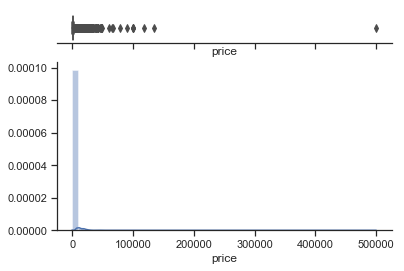

In [78]:
## Distribution and box plot of the raw data with outliers
distWithBox('price')

For normally distributed data, the skewness should be about 0. A skewness value > 0 means that there is more weight in the left tail of the distribution. The function skewtest can be used to determine if the skewness value is close enough to 0, statistically speaking.

In [79]:
from scipy.stats import skew
from scipy.stats import skewtest
skew(df['price'])


49.71356722842452

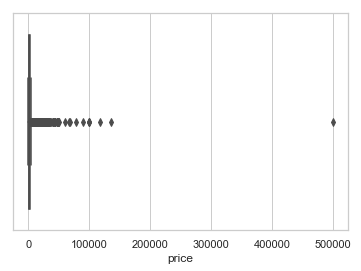

In [80]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x=df['price'])

We can see from the the distribution plot, the skewtest and the box plot that price is not normally distributed. The price  data is right skewed and there are outlier values that need to be handled.

When a data set has outliers or extreme values, we summarize a typical value using the median as opposed to the mean.  When a data set has outliers, variability is often summarized by a statistic called the interquartile range, which is the difference between the first and third quartiles. The first quartile, denoted Q1, is the value in the data set that holds 25% of the values below it. The third quartile, denoted Q3, is the value in the data set that holds 25% of the values above it. The quartiles can be determined following the same approach that we used to determine the median, but we now consider each half of the data set separately. The interquartile range is defined as follows:

Interquartile Range(IQR) = Q3-Q1

Outliers are values  1.5*IQR below Q1 or above Q3 or equivalently, values below Q1-1.5 IQR or above Q3+1.5 IQR.
These are referred to as Tukey fences.


In [81]:
from numpy import percentile
data=df['price']
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles:\n\t25th=%.3f \n\t75th=%.3f \n\tIQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers) )
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles:
	25th=1045.000 
	75th=2195.000 
	IQR=1150.000
Identified outliers: 4619
Non-outlier observations: 94981


In [82]:
outliers=[] 
data_1=df['price'] 
for item in data_1:
    if item <lower or item>upper:
        outliers.append(item)


In [83]:
x=df['price']
outlier_indices=list(data_1.index[(x<lower) | (x> upper)])

In [84]:
len(outlier_indices)

4619

In [85]:
df.drop(axis=0,index=outlier_indices, inplace=True)

In [86]:
df.shape

(94981, 49)

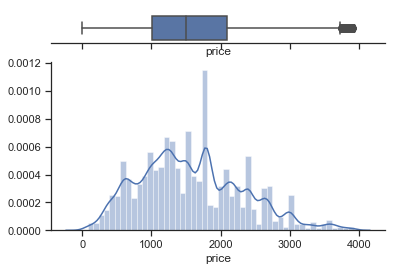

In [87]:
## lets plot distribution with and box plot to see the change after we trim down the outliers
distWithBox('price')

## Feature Selection


VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

threshold .8 * (1 - .8)

Using 0.8 as a threshhold, we will remove features with less than 20 percent variation within itself. 

In [88]:
df_X=df.loc[:, df.columns != 'price']
df_y=df['price']

In [89]:
from sklearn.feature_selection import VarianceThreshold
print('%s Number of features before VarianceThreshhold'%len(df_X.columns))

selector=VarianceThreshold(threshold=(.8*(1-.8)))
FeaturesTransformed=selector.fit_transform(df_X)

## print the support and shape of the transformed features
print(selector.get_support())


48 Number of features before VarianceThreshhold
[ True  True False  True False False  True  True  True False False  True
 False False False  True  True  True  True False  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False]


In [90]:
data=df_X[df_X.columns[selector.get_support(indices=True)]]
cols=data.columns

In [91]:
df_reduced=pd.DataFrame(FeaturesTransformed, columns=cols)
df_reduced.shape

(94981, 37)

In [92]:
data=df_reduced
target=df_y

In [93]:
data.shape

(94981, 37)

# Yellowbrick for Feature Selection

we are using yellowbrick's feature selection method for finding and selecting the most useful features and eliminate zero importance features from the dataset.


### Important Features for Random Forest Regressor

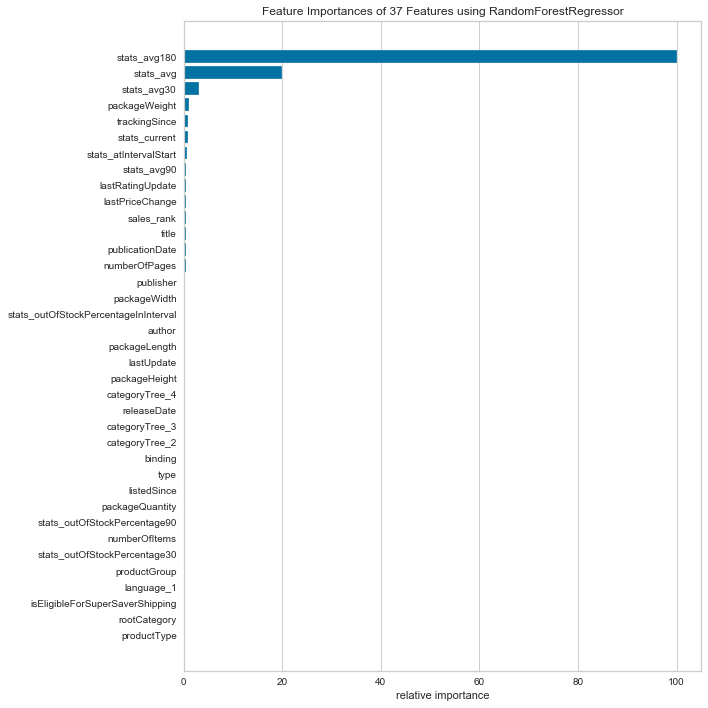

In [94]:
#Using yellowbrick feature selection method with random forest regressor
from sklearn.ensemble import RandomForestRegressor

from yellowbrick.features.importances import FeatureImportances

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

viz = FeatureImportances(RandomForestRegressor(), ax=ax)
viz.fit(data, target)
viz.poof()

In [95]:
feature_importances = pd.DataFrame(viz.feature_importances_,
                                   index=data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [96]:
## important features for Random Forest Regression
RF_importants=feature_importances.index[feature_importances.importance!=0]

In [97]:
df[RF_importants].shape

(94981, 37)

In [98]:
# predicting price using random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as split
X=df[RF_importants]
Y=df['price']
model=RandomForestRegressor()
X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)
model.fit(X_train,Y_train)
Y_test=model.predict(X_test)

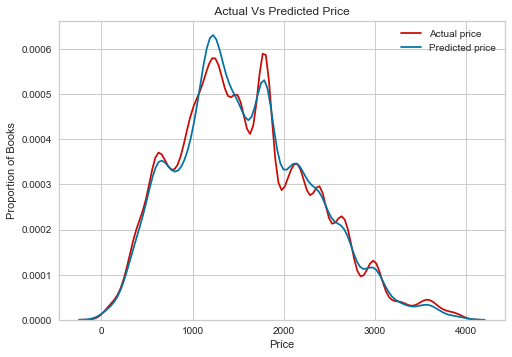

In [99]:
ax1=sns.distplot(target,hist=False, color='r',label="Actual price")
sns.distplot(Y_test,hist=False,color='b', label="Predicted price", ax=ax1)
plt.title(" Actual Vs Predicted Price ")
plt.xlabel('Price')
plt.ylabel('Proportion of Books')
plt.show()

### Important Features for Gradient Boosting Regressor

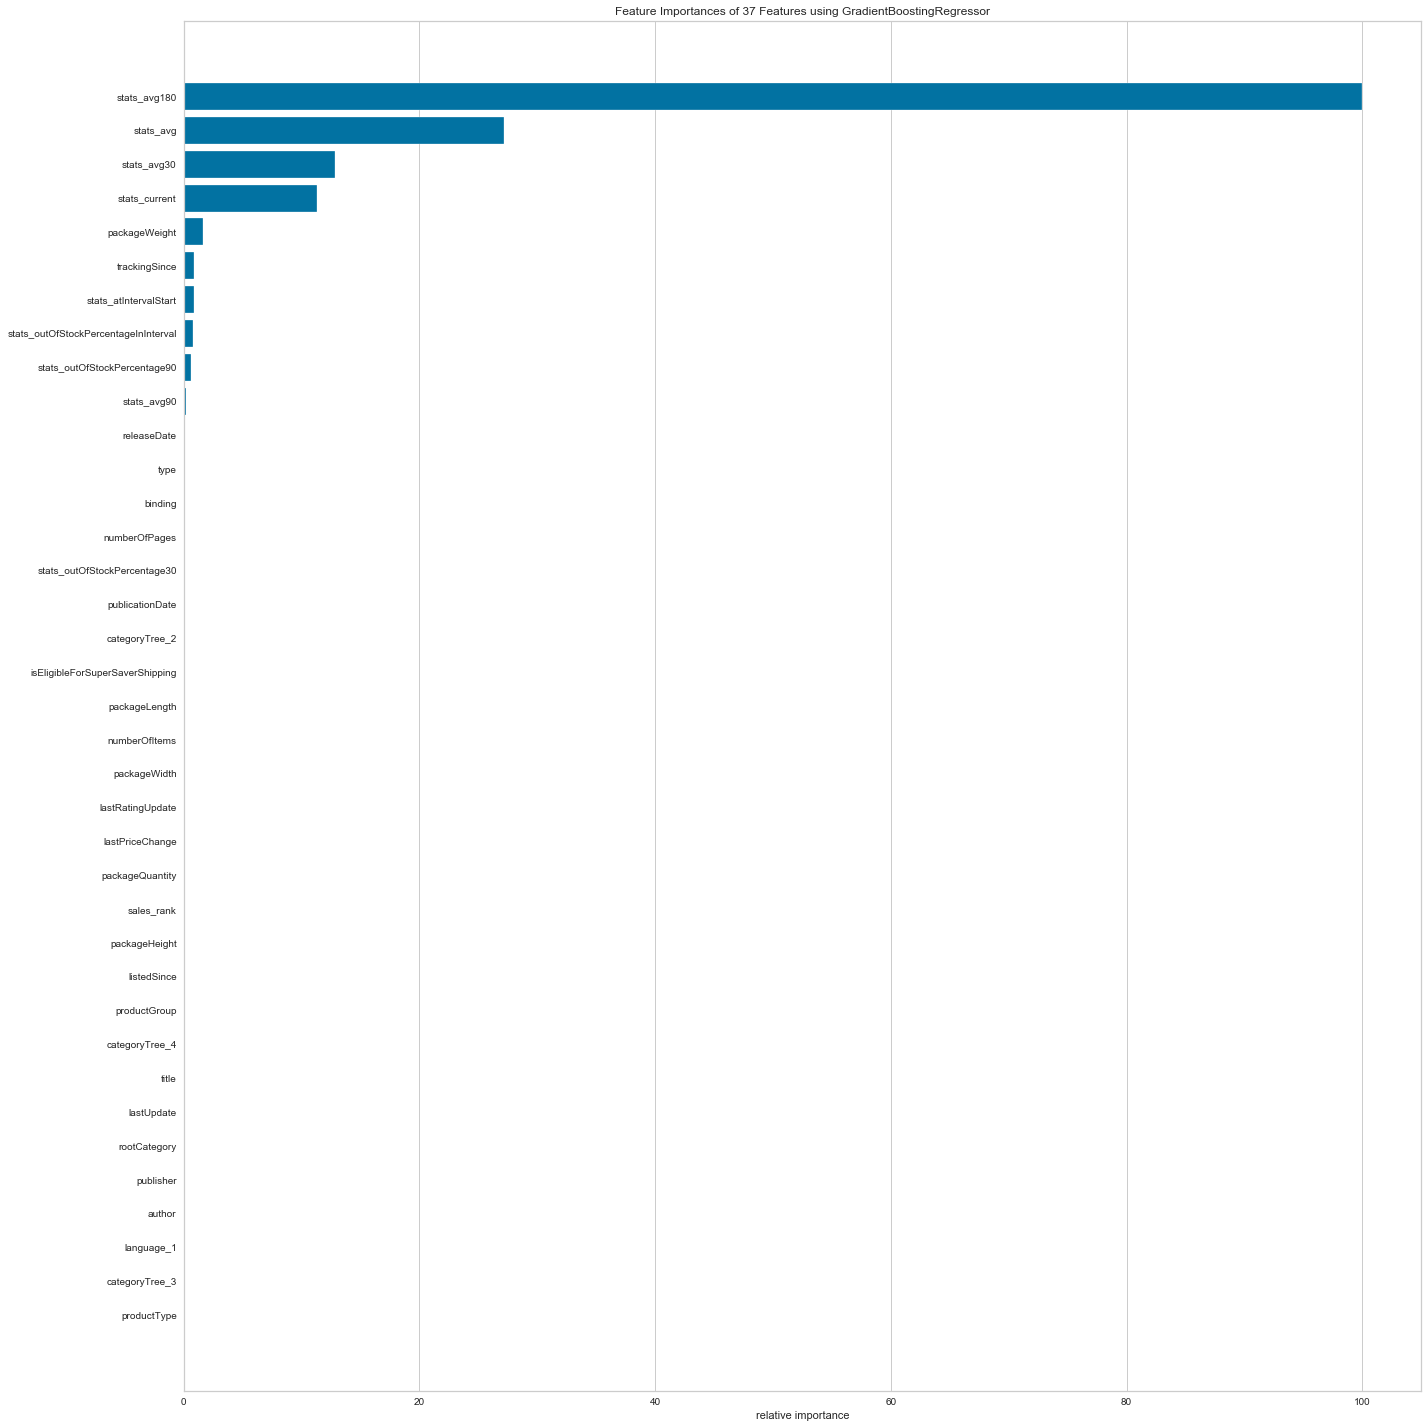

In [100]:
from sklearn.ensemble import GradientBoostingRegressor

from yellowbrick.features.importances import FeatureImportances

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingRegressor(), ax=ax)
viz.fit(data, target)
viz.poof()

In [101]:
feature_importances = pd.DataFrame(viz.feature_importances_,
                                   index=data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [102]:
## important features for gradient boosting regression
GBR_importants=feature_importances.index[feature_importances.importance!=0]

In [103]:
df[GBR_importants].shape

(94981, 33)

In [104]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split as split
X=df[GBR_importants]
Y=df['price']
model=GradientBoostingRegressor()
X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)
model.fit(X_train,Y_train)
Y_test=model.predict(X_test)

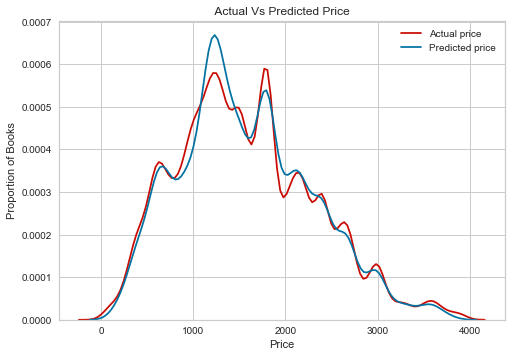

In [105]:
ax1=sns.distplot(target,hist=False, color='r',label="Actual price")
sns.distplot(Y_test,hist=False,color='b', label="Predicted price", ax=ax1)
plt.title(" Actual Vs Predicted Price ")
plt.xlabel('Price')
plt.ylabel('Proportion of Books')
plt.show()

### Important Features for Decision Tree Regressor

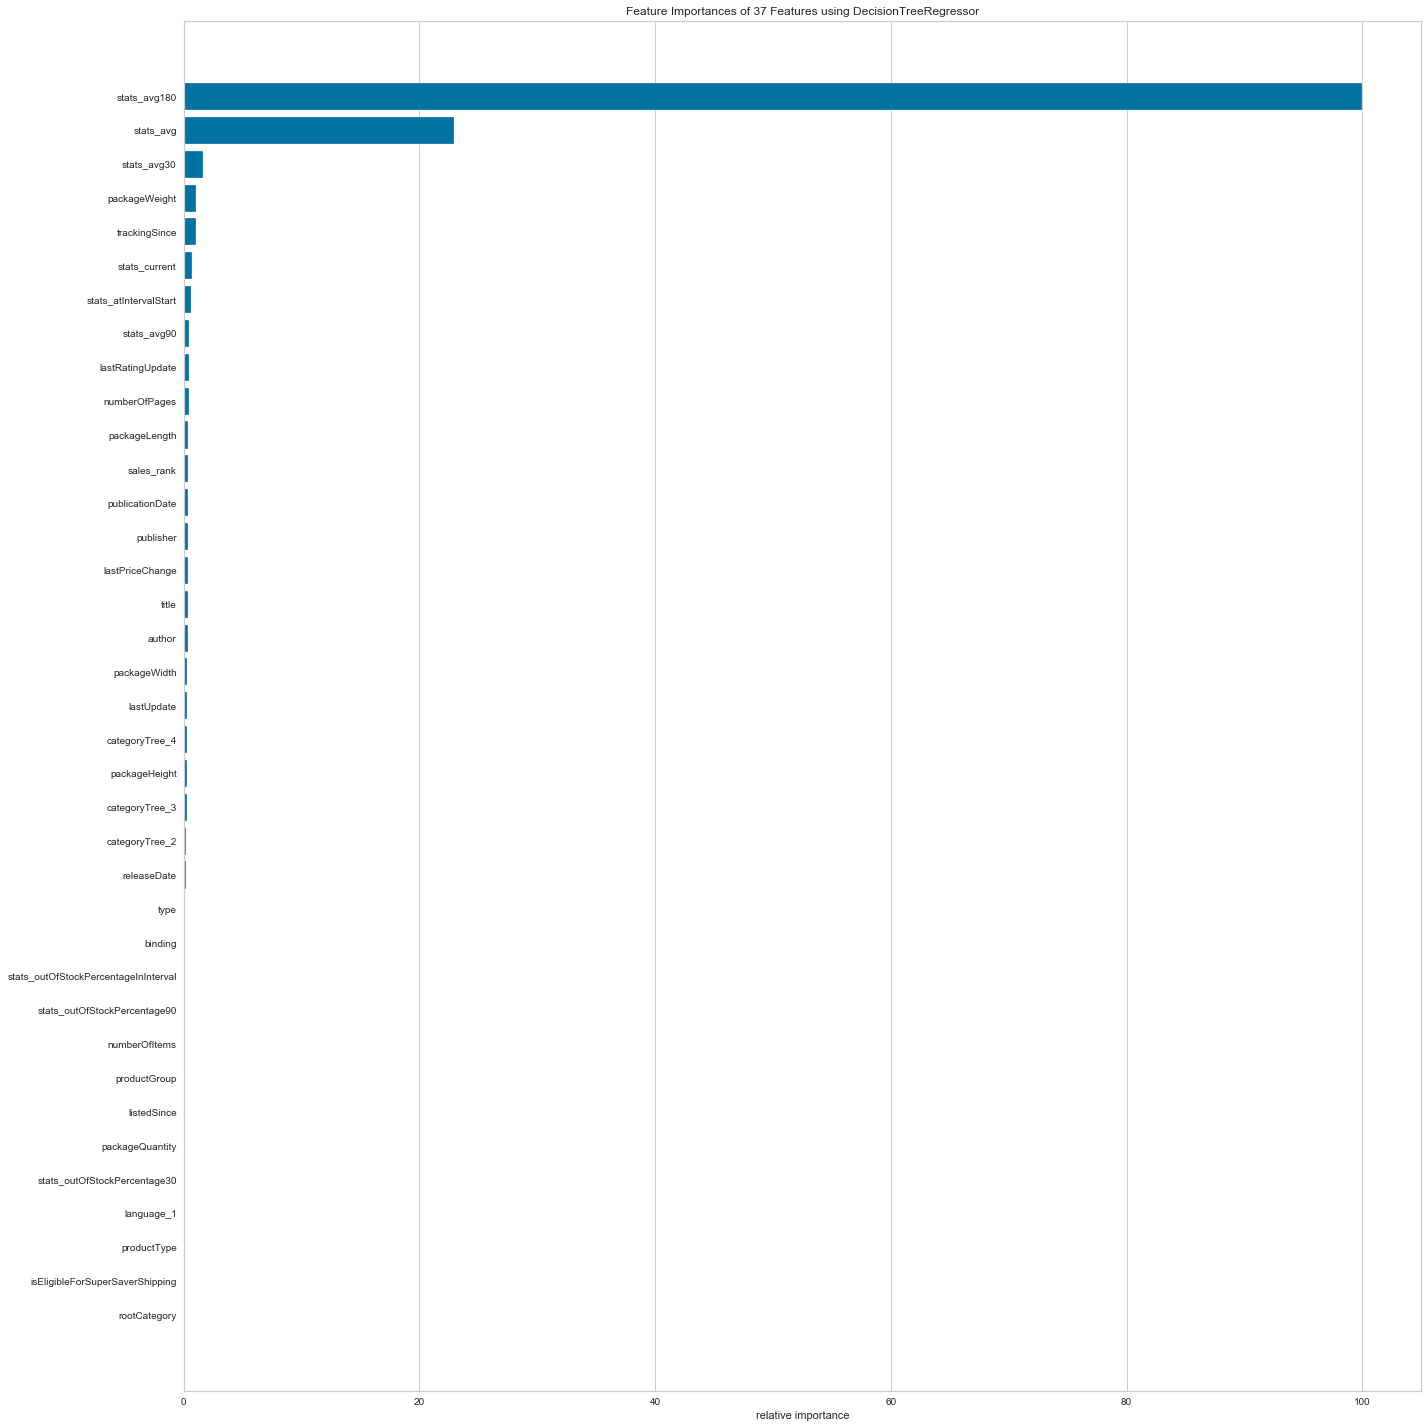

In [106]:
from sklearn.tree import DecisionTreeRegressor

from yellowbrick.features.importances import FeatureImportances

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()

viz = FeatureImportances( DecisionTreeRegressor(), ax=ax)
viz.fit(data, target)
viz.poof()

In [107]:
feature_importances = pd.DataFrame(viz.feature_importances_,
                                   index=data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [108]:
## important features for decision tree regression
DTR_importants=feature_importances.index[feature_importances.importance!=0]

In [109]:
df[DTR_importants].shape

(94981, 36)

In [110]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split as split
X=df[DTR_importants]
Y=df['price']
model=DecisionTreeRegressor()
X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)
model.fit(X_train,Y_train)
Y_test=model.predict(X_test)

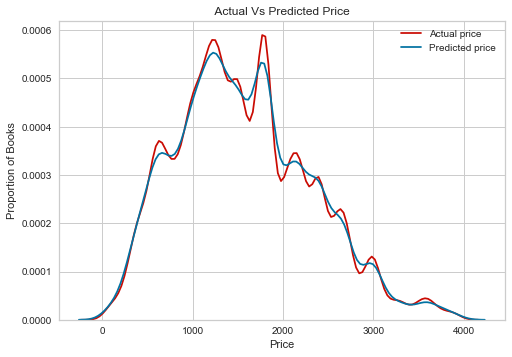

In [111]:
ax1=sns.distplot(target,hist=False, color='r',label="Actual price")
sns.distplot(Y_test,hist=False,color='b', label="Predicted price", ax=ax1)
plt.title(" Actual Vs Predicted Price ")
plt.xlabel('Price')
plt.ylabel('Proportion of Books')
plt.show()

## Model Development
In this section we will implement several models that will predict price using the dependent variables and compare the accuracy, r-score, goodness of fit and plot residuals. Based on the scores and visual comparison of the plots, we will refine the best performing models using grid search to fine tune the hyperparameters to generate a better predictive model. 

In [112]:
# This function applies multiple models on the data and returns model name with r2-score and mean squared error value
def ModelScores(data,target):
    X=data
    Y=target
    
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    import math
    from sklearn.model_selection import train_test_split as split
    X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)
    
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.neural_network import MLPRegressor
    from sklearn.linear_model import RidgeCV
    from sklearn.linear_model import LassoLars
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import ElasticNet
    from sklearn.linear_model import BayesianRidge
    from sklearn.linear_model import RANSACRegressor

    models={'Gradient Boost': GradientBoostingRegressor(),
            'Random Forest': RandomForestRegressor(),
            'Decision Tree': DecisionTreeRegressor(),
            'Linear Regression': LinearRegression(),
            'MLP': MLPRegressor(),
            'Ridge CV': RidgeCV(),
            'LassoLars':LassoLars(),
            'Lasso':Lasso(),
            'Elastic Search': ElasticNet(),
            'Bayesian Ridge':BayesianRidge(),
            'Ransac':RANSACRegressor()      
           }
    for name,model in models.items():
        mdl=model
        mdl.fit(X_train, Y_train)
        prediction = mdl.predict(X_test)
        print(name)
        print("Accuracy Score", r2_score(Y_test, prediction))
        mse3 = mean_squared_error(Y_test, prediction)
        print("The root mean square value", math.sqrt(mse3))

In [113]:
data= data
target=df['price']
ModelScores(data, target)

Gradient Boost
Accuracy Score 0.9367369081600733
The root mean square value 186.89289388581778
Random Forest
Accuracy Score 0.9337976120860896
The root mean square value 191.1852615390763
Decision Tree
Accuracy Score 0.8823960757022526
The root mean square value 254.8170532112405
Linear Regression
Accuracy Score 0.3394498212973682
The root mean square value 603.9075919839008
MLP
Accuracy Score -24342495.887379576
The root mean square value 3666064.8557382645
Ridge CV
Accuracy Score -3.574138728143758e+41
The root mean square value 4.442252954172871e+23
LassoLars
Accuracy Score 0.6205168287618223
The root mean square value 457.734706363672
Lasso
Accuracy Score 0.8548904938243855
The root mean square value 283.0515348738743
Elastic Search
Accuracy Score 0.8502261115053912
The root mean square value 287.5647408013992
Bayesian Ridge
Accuracy Score -7055.092069781869
The root mean square value 62416.54162720075
Ransac
Accuracy Score -15132884.06758916
The root mean square value 2890536.4416

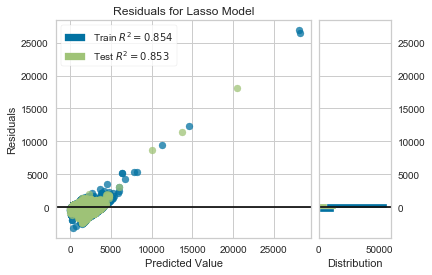

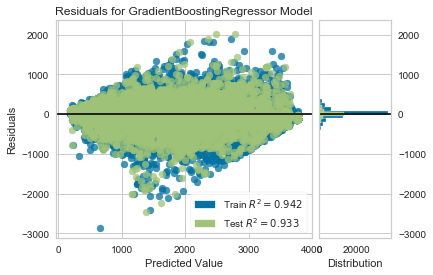

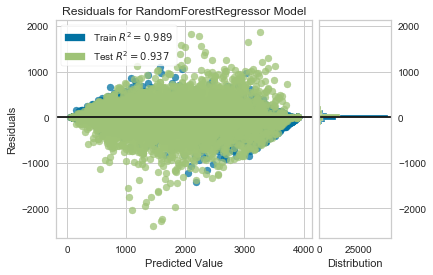

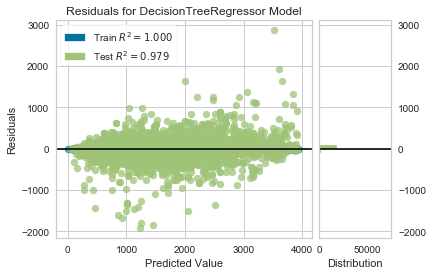

In [114]:
%matplotlib inline
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

regressors = {
    "Lasso": Lasso(),
    "Gradient Boost": GradientBoostingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor()
    
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, Y_train)
    visualizer.score(X_test, Y_test)
    visualizer.poof()

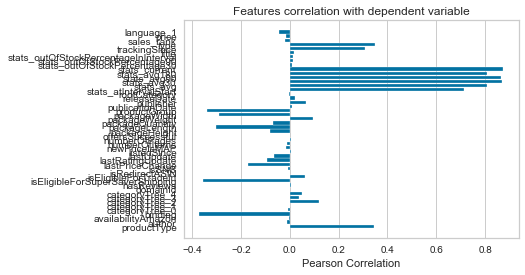

In [115]:
from yellowbrick.target import FeatureCorrelation
feature_names = np.array(df.columns)
data=df.loc[:, df.columns != 'price']
target=df['price']
figsize=(20, 20)
visualizer = FeatureCorrelation(labels=feature_names)
visualizer.fit(data, target)
visualizer.poof()

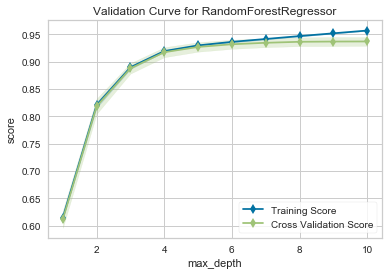

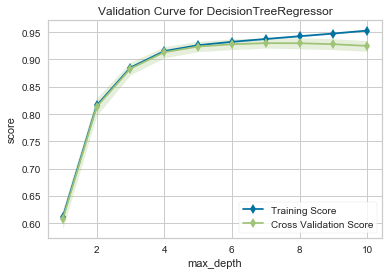

In [116]:
#validation curve for decision tree regression and Random forest regression models

from yellowbrick.model_selection import ValidationCurve

# Extract the instances and target
X = df_X
y = df_y

regressors = {
        "Random Forest": RandomForestRegressor(),
        "Decision Tree": DecisionTreeRegressor()    
}
for _, regressor in regressors.items():
    viz = ValidationCurve(
        regressor, param_name="max_depth",
        param_range=np.arange(1, 11), cv=10, scoring="r2"
    )
    # Fit and poof the visualizer
    viz.fit(X, y)
    viz.poof()


We will use the validation curve from the above thee figures to narrow down the optimal 'max_depth' value range to use, for hyperparameter tuning in a  grid search.

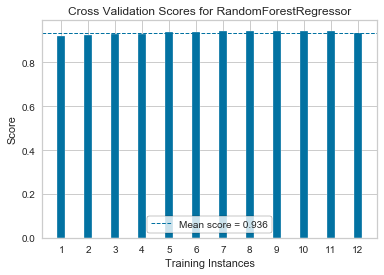

In [117]:
# Cross Validation Score for Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores

ind=df[RF_importants].values
dep=df['price'].values

_, ax = plt.subplots()
cv = StratifiedKFold(n_splits=12, random_state=42)
oz = CVScores(
    RandomForestRegressor(), ax=ax, cv=cv, scoring='r2'
)

oz.fit(ind, dep)
oz.poof()


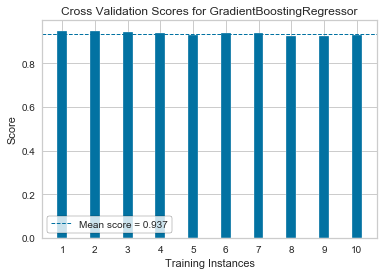

In [118]:
# CV score for Gradiet Boosting Regresor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores

ind=df[GBR_importants].values
dep=df['price'].values

_, ax = plt.subplots()
cv = StratifiedKFold(n_splits=12, random_state=42)
cv = KFold(10)
oz = CVScores(
    GradientBoostingRegressor(), ax=ax, cv=cv, scoring = 'r2'
)

oz.fit(ind, dep)
oz.poof()



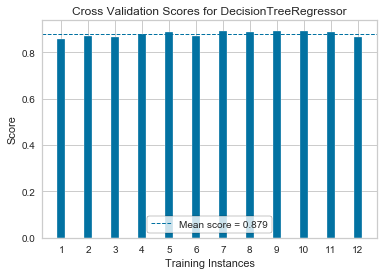

In [119]:
# CV score for Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores

ind=df[DTR_importants].values
dep=df['price'].values

_, ax = plt.subplots()
cv = StratifiedKFold(n_splits=12, random_state=42)
oz = CVScores(
    DecisionTreeRegressor(), ax=ax, cv=cv, scoring = 'r2'
)

oz.fit(ind, dep)
oz.poof()


## Hyperparameter Tuning

In [120]:
# hyper-parameter tunung for decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

DecisionTree = DecisionTreeRegressor(random_state = 40)

min_samples_split = [2,3,4,5,6,7,8]
min_samples_leaf = [1,2,3,4,5]
max_depth = [4,5,6,7,8,9]
tuned_params = [{'min_samples_split': min_samples_split}, {'min_samples_leaf': min_samples_leaf},{'max_depth': max_depth}]
n_folds = 5

X=df[DTR_importants]
Y=df['price']

grid = GridSearchCV(
    DecisionTree, tuned_params, cv=n_folds
)

grid.fit(X, Y)
print(grid.best_estimator_)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=40, splitter='best')


In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

GradientBoosting = GradientBoostingRegressor(random_state = 40)
alphas = [0.001, 0.01, 0.1, 0.5, 0.9]
sample_split = [2,3,4,5,6,7,8]
max_depth = [4,5,6,7,8,9]
learning_rate = [0.1, 0.3, 0.5, 0.7]
tuned_params = [{'alpha': alphas}, {'min_samples_split': sample_split}, {'max_depth': max_depth}, {'learning_rate':learning_rate}]
n_folds = 5

X=df[GBR_importants]
Y=df['price']

grid = GridSearchCV(
    GradientBoosting, tuned_params, cv=n_folds
)

grid.fit(X, Y)
print(grid.best_estimator_)




GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=40, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

RandomForest = RandomForestRegressor(random_state = 40)

estimators = [10,50,100]
sample_split = [2,3,4,5,6,7,8]
sample_leaf = [1,2,3,4,5]
max_depth = [4,5,6,7,8,9]
tuned_params = [{'n_estimators': estimators}, {'min_samples_split': sample_split}, {'min_samples_leaf': sample_leaf},{'max_leaf_nodes': max_depth}]
n_folds = 5

X=df[RF_importants]
Y=df['price']

grid = GridSearchCV(
    RandomForest, tuned_params, cv=n_folds
)

grid.fit(X, Y)
print(grid.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=40, verbose=0, warm_start=False)


## Model Evaluation
In this part we are using the result that we obtained from the grid search as an input to retrain our models. The grid search is applied with cross validation by taking the average score over 12 folds. 

In [123]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
X=df[DTR_importants]
Y=df['price']
X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)

from sklearn.tree import DecisionTreeRegressor
model=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=40, splitter='best')

model.fit(X_train,Y_train)
prediction13 = model.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction13))
mse = mean_squared_error(Y_test, prediction13)
print("The root mean square value", math.sqrt(mse))

Accuracy Score 0.927795810834849
The root mean square value 199.66354597996684


In [124]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
X=df[GBR_importants]
Y=df['price']
X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
model=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=40, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
model.fit(X_train,Y_train)
prediction13 = model.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction13))
mse = mean_squared_error(Y_test, prediction13)
print("The root mean square value", math.sqrt(mse))

Accuracy Score 0.9394475703194354
The root mean square value 182.8451180288185


In [125]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
X=df[RF_importants]
Y=df['price']
X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=40, verbose=0, warm_start=False)
rfg.fit(X_train, Y_train)
prediction14 = rfg.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction14))
mse2 = mean_squared_error(Y_test, prediction14)
print("The root mean square value", math.sqrt(mse2))


Accuracy Score 0.9404086092584173
The root mean square value 181.3883301353828


http://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_summarizingdata/bs704_summarizingdata7.html